In [48]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

利用函数`sort_key`对加载进来的文件进行排序，文件名用`basename`函数获取，截取其中[4:-4]子串，这是电池编号，以此来排序

In [49]:
def sort_key(s):
    return int(os.path.basename(s)[4:-4])

def load_dataset(folder):
    files = glob.glob('../../data/battery_data/'+folder+'/*.csv')
    files.sort(key=sort_key) # glob returns list with arbitrary order
    
    l = len(files)
    dataset = np.zeros((l,1000,99))
    for k, file in enumerate(files):
        cell = np.genfromtxt(file,delimiter=',')
        dataset[k,:,:] = cell # flip voltage dimension
    return dataset

train_data = load_dataset('train')
test1_data = load_dataset('test1')
test2_data = load_dataset('test2')

用平滑样条拟合每条放电电压-容量曲线，然后在1000个均匀间隔的电压点对每个样条进行采样。因此，对于一个跨度为1.6V（3.6-2.0V）的工作窗口，每个容量样本之间的距离为1.6mV。

每个电池测量了前100个循环内的数据。

In [50]:
cellNum = 10
sample = train_data[cellNum,:,:]
Vdlin = np.linspace(3.6,2,1000)

sample,sample.shape

(array([[-1.6684e-04, -2.0348e-04, -1.4681e-04, ..., -3.9094e-04,
         -1.9957e-04, -3.7325e-04],
        [-1.3877e-04, -1.7366e-04, -1.1976e-04, ..., -3.5263e-04,
         -1.7103e-04, -3.4327e-04],
        [-1.1189e-04, -1.4442e-04, -9.3726e-05, ..., -3.1557e-04,
         -1.4280e-04, -3.1287e-04],
        ...,
        [ 1.0729e+00,  1.0742e+00,  1.0748e+00, ...,  1.0692e+00,
          1.0692e+00,  1.0690e+00],
        [ 1.0729e+00,  1.0742e+00,  1.0749e+00, ...,  1.0692e+00,
          1.0692e+00,  1.0690e+00],
        [ 1.0729e+00,  1.0742e+00,  1.0749e+00, ...,  1.0693e+00,
          1.0693e+00,  1.0690e+00]]),
 (1000, 99))

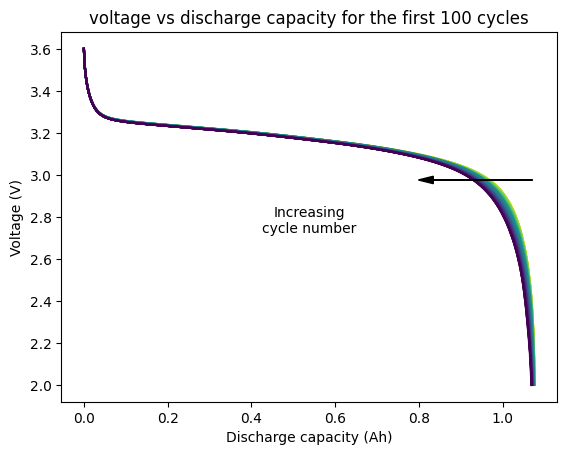

In [51]:
colors = cm.get_cmap('viridis_r')(np.linspace(0, 1, 99))
plt.title('voltage vs discharge capacity for the first 100 cycles')

for k in np.arange(99):
    plt.plot(sample[:,k],Vdlin,color=colors[k])
plt.xlabel('Discharge capacity (Ah)')
plt.ylabel('Voltage (V)')

plt.arrow(0.95, 0.6, -0.2, 0, transform=plt.gca().transAxes,zorder=3,head_width=0.02,color='k')
plt.text(0.5, 0.49, 'Increasing\ncycle number', horizontalalignment='center',
     verticalalignment='center',transform=plt.gca().transAxes)

plt.savefig('../../figures/battery_figs/Voltage vs Discharge capacity.png')

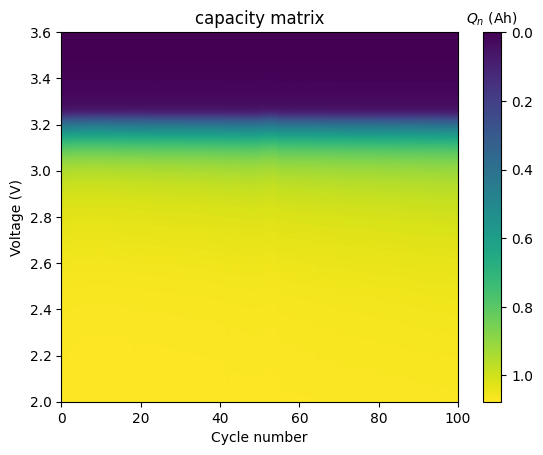

In [52]:
plt.imshow(sample, extent=[0,100,3.6,2.0], aspect='auto', origin='lower')
plt.title('capacity matrix')
plt.xlabel('Cycle number')
plt.ylabel('Voltage (V)')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.ax.set_title(r'$Q_n$'+' (Ah)',fontsize=10)
cbar.ax.invert_yaxis() 

plt.savefig('../../figures/battery_figs/capacity matrix.png')

(1000, 99)


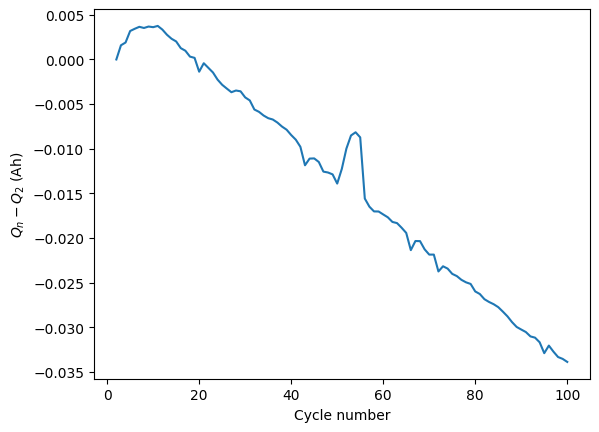

In [53]:
Qsub = (sample[:,:].T - sample[:,0]).T
print(Qsub.shape)
plt.plot(np.arange(2,101),Qsub[400,:])
plt.xlabel('Cycle number')
plt.ylabel(r'$Q_n-Q_2$'+' (Ah)')
plt.savefig('../../figures/battery_figs/Qn-Q2.png')

In [54]:
# Qdiv = (sample[:,:].T / sample[:,0]).T

# plt.title('f',loc='left',weight='bold')
# plt.plot(np.arange(2,101),Qdiv[400,:])
# plt.xlabel('Cycle number')
# plt.ylabel(r'$Q_n/Q_2$'+' (Ah)')

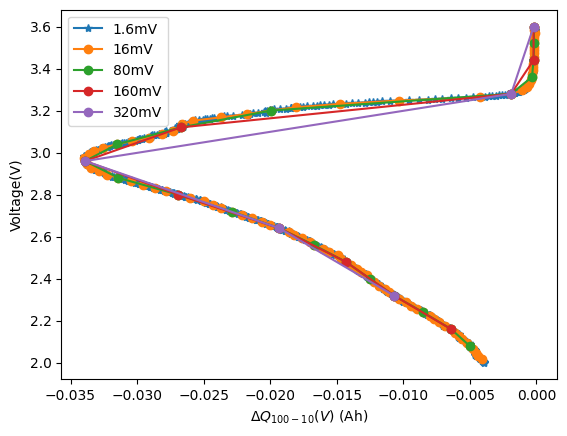

In [55]:
sample_cycle = Qsub[:,98]
plt.plot(sample_cycle,Vdlin,'*-',label='1.6mV') # 1000 points, 1.6mV
# plt.plot(sample_cycle[0:-1:2],Vdlin[0:-1:2],'o-') # 500 points, 3.2mV
# plt.plot(sample_cycle[0:-1:4],Vdlin[0:-1:4],'o-') # 250 points, 6.4mV
plt.plot(sample_cycle[0:-1:10],Vdlin[0:-1:10],'o-',label='16mV') # 100 points, 16mV
plt.plot(sample_cycle[0:-1:50],Vdlin[0:-1:50],'o-',label='80mV') # 20 points, 80mV
plt.plot(sample_cycle[0:-1:100],Vdlin[0:-1:100],'o-',label='160mV') # 10 points, 160mV
plt.plot(sample_cycle[0:-1:200],Vdlin[0:-1:200],'o-',label='320mV') # 5 points, 320mV
plt.xlabel(r'$\Delta Q_{100-10}(V)$'+' (Ah)')
plt.ylabel('Voltage(V)')

plt.legend()
plt.savefig('../../figures/battery_figs/sampling.png')
# sample_cycle.shape,Vdlin.shape